In [ ]:
!pip install yfinance

     |████████████████████████████████| 5.5MB 25.0MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22618 sha256=6db0b63e37f22ccd294bd4d9e051c6a0b7e9d7f672e54ef747fd48355f5204cd
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
!pip install chart_studio

     |████████████████████████████████| 71kB 6.3MB/s 


In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd
import torch
import torch.nn as nn
import math, time
import plotly.express as px
import plotly.graph_objects as go
import chart_studio.plotly as py
import chart_studio
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

[*********************100%***********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2738 entries, 2010-01-04 to 2020-11-16
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2738 non-null   float64
dtypes: float64(1)
memory usage: 42.8 KB
x_train.shape =  (2174, 19, 1)
y_train.shape =  (2174, 1)
x_test.shape =  (544, 19, 1)
y_test.shape =  (544, 1)
Epoch  0 MSE:  0.8571082949638367


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Epoch  1 MSE:  0.6074901819229126
Epoch  2 MSE:  0.3427373468875885
Epoch  3 MSE:  0.0851360410451889
Epoch  4 MSE:  0.15509791672229767
Epoch  5 MSE:  0.14741486310958862
Epoch  6 MSE:  0.07474703341722488
Epoch  7 MSE:  0.050626207143068314
Epoch  8 MSE:  0.062376976013183594
Epoch  9 MSE:  0.07881142199039459
Epoch  10 MSE:  0.085939921438694
Epoch  11 MSE:  0.08305534720420837
Epoch  12 MSE:  0.07415030151605606
Epoch  13 MSE:  0.06384198367595673
Epoch  14 MSE:  0.055821992456912994
Epoch  15 MSE:  0.05215203016996384
Epoch  16 MSE:  0.05293650925159454
Epoch  17 MSE:  0.05646953359246254
Epoch  18 MSE:  0.06008515879511833
Epoch  19 MSE:  0.06153170391917229
Epoch  20 MSE:  0.06006333976984024
Epoch  21 MSE:  0.05651552230119705
Epoch  22 MSE:  0.05249175429344177
Epoch  23 MSE:  0.04939025267958641
Epoch  24 MSE:  0.0478433296084404
Epoch  25 MSE:  0.04767810180783272
Epoch  26 MSE:  0.04820479825139046
Epoch  27 MSE:  0.04859031364321709
Epoch  28 MSE:  0.0481625460088253
Epoch

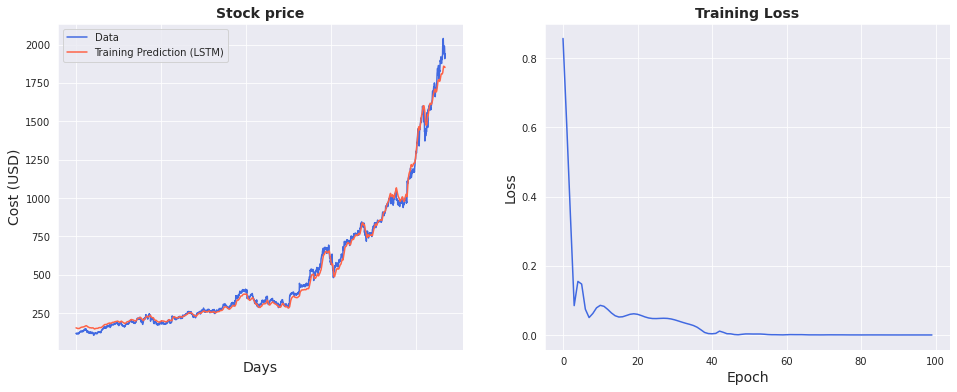

In [ ]:
# download 'Amazon' data from yahoo finance
data = yf.download("AMZN",start = "2010-01-01",end = "2020-11-17")

# using close data
price = data[["Close"]]
price.info()
scaler = MinMaxScaler(feature_range=(-1, 1))
price["Close"] = scaler.fit_transform(price["Close"].values.reshape(-1,1))

# define train data(80%) and test data(20%) 
def split_data(stock, lookback):
    # convert to numpy array
    data_raw = stock.to_numpy() 
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    return [x_train, y_train, x_test, y_test]

# choose sequence length
lookback = 20 
x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

# convert to Tensor
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

# setup dimension and layer 
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

# create LSTM model
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out
    
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
# lr = 0.01
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

# invert data
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

# plot setup
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

trainPredictPlot = np.empty_like(price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(price)-1, :] = y_test_pred

original = scaler.inverse_transform(price['Close'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (USD)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (LSTM)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()